# The Hopfield Network

The Hopfield network is an artificial neural network that stores a set of patterns as attractors of its dynamics. The state of the network is represented by a vector $S_i$ for $i = 1, \cdots, N$, where $N$ is the number of nodes in the network. We will consider nodes that can only take discrete values $\pm 1$. The dynamics of the network is described by the update rule:
\begin{equation}
S_i (t+1) = \operatorname{sgn} \Big( \sum_j J_{ij} S_j (t) \Big)
\end{equation}
Here the matrix $J_{ij}$ represents the connections between the nodes.

There are two ways to implement the update of all nodes. One way is to update all nodes together at the same time, which is called a "synchronous" update. The other way is to update the nodes one at a time, which is called "asynchronous". These are not equivalent because in the synchronous update, the new value of each node depends on the old values of all nodes, whereas in the asynchronous update, even if we sweep over all nodes in each round of updates, the new value of a node will depend on the new values of the nodes that have already been updated in the same round (and the old values of those not yet updated). The latter scheme may be considered more realistic biologically. In order to avoid bias, we will choose a random order to update the nodes, which introduces some stochasticity in the dynamics.

A pattern is a state of the network where each node takes a specific value $\xi_i = \pm 1$. For a given pattern $\xi_i$ to be stored in the network, it has to be a stable steady state of the dynamics. In that case, if we initialize the network at a state close to the pattern (a "seed" state), the network will follow its dynamics and converge to the steady state, thus retrieving the stored pattern. Hopfield found a simple form of $J_{ij}$ that allows the network to store multiple patterns, $\xi_i^\mu$ for $\mu = 1, \cdots, M$ (think of each $\xi^\mu$ as a vector with components $\xi_i^\mu$). That is,
\begin{equation}
J_{ij} = \frac{1}{N} \sum_{\mu=1}^{M} \xi^\mu_i \xi^\mu_j
\end{equation}
With this connection matrix, each pattern $\xi^\mu$ is a locally stable steady state. Therefore, if we provide a seed to the network that is close to one of the patterns, the network will automatically retrieve the correct full pattern.

Let us implement the Hopfield network as follows. First, we will write a base class to represent a general network with an arbitrary connection matrix, the dynamics of which is given by the update rule above. Such a network in which every node can be connected to all other nodes is called "recurrent" (more precisely, a recurrent network has a connnectivity graph that has cycles).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class RecurrentNetwork:
    """
    base class of neural network with recurrent connection matrix
    """

    def __init__(self, N, sync=False):
        """
        declare internal variables.
        inputs:
        N: int, number of neurons forming the network.
        init: 1-d array, initial state of the network.
        sync: bool, whether to update synchronously.
        """
        self.N = int(N)    # number of neurons
        self.state = np.zeros(self.N, dtype=int)    # state of neurons, S_i
        self.connect = np.zeros((self.N,self.N))    # connection matrix, J_{ij}
        self.sync = sync

    def set_network(self, state=None, connect=None):
        """
        set state and connection of the network.
        inputs:
        state: 1-d array, state of neurons to be set.
        connect: 2-d array, connection matrix to be set.
        """
        if state is not None:
            self.state = np.asarray(state, dtype=int)
        if connect is not None:
            self.connect = np.asarray(connect, dtype=float)

    def update1(self, i):
        """
        update one neuron of given index, as well as its effect on others.
        inputs:
        i: int, index of neuron to be updated.
        outputs:
        b: bool, whether the state of given neuron is changed.
        """
        s = np.sign(self.input[i]).astype(int)
        if s != self.state[i]:
            self.state[i] = s
            self.input += 2*s*self.connect[:,i]
            return True
        else:
            return False

    def updateN(self, size=None, replace=True):
        """
        update many neurons in random sequential order.
        inputs:
        size: number of neurons to update in a sweep, default is `self.N`.
        replace: whether to sample neurons with replacement.
        outputs:
        flip_any: bool, whether the state of any neuron is changed.
        """
        if size is None:
            size = self.N
        seq = np.random.choice(np.arange(self.N), size=size, replace=replace)
        self.input = np.dot(self.connect, self.state)
        flip_any = False
        if self.sync:    # update synchronously
            new_state = self.act(self.input[seq]).astype(int)
            flip_any = np.any(new_state != self.state[seq])
            self.state[seq] = new_state
        else:    # update asynchronously
            for i in seq:
                flip = self.update1(i)
                flip_any = (flip_any or flip)
        return flip_any

Then we will define a derived class to implement the Hopfield model by specifying the connection matrix. We will also define a method `Hopfield.overlap()` that calculates the overlap between the state of the network and given patterns.

In [3]:
class Hopfield(RecurrentNetwork):
    """
    Hopfield network that stores patterns as attractors.
    """

    def __init__(self, patterns, **kwargs):
        """
        create Hopfield network from a set of patterns to be stored.
        inputs:
        patterns: 2-d array, each row is a pattern.
        """
        N = np.shape(patterns)[1]    # size of network
        RecurrentNetwork.__init__(self, N, **kwargs)
        self.p = 0    # number of stored patterns
        self.patterns = np.zeros((0,N))    # stored patterns, xi_i^mu
        self.store(patterns)

    def store(self, new_patterns):
        """
        store new patterns into the connection matrix.
        inputs:
        new_patterns: 2-d array, each row is a new pattern.
        outputs:
        sym: 2-d array, updated symmetric connection matrix.
        """
        new_patterns = np.reshape(new_patterns, (-1,self.N)).astype(float)
        self.p += new_patterns.shape[0]
        self.patterns = np.vstack([self.patterns, new_patterns])
        self.connect += np.dot(new_patterns.T, new_patterns) / self.N
        return self.connect

    def overlap(self, mu=None):
        """
        calculate overlap between network state and each pattern.
        inputs:
        mu: int or 1-d array, index of pattern(s), if None, calculate for all.
        outputs:
        m_mu: real or 1-d array, overlap for given pattern(s).
        """
        if mu is None:
            mu = np.arange(self.p)
        m_mu = np.dot(self.state, self.patterns[mu].T) / self.N
        return m_mu

Let us test the Hopfield network's ability to retrieve stored patterns. First, let us select some patterns for the network to store. To better visualize the process, we will use images as our patterns. These will be black and white images, such that each pixel takes a value 0 (black) or 1 (white). Each pixel corresponds to one node in the network. Let us load some images.

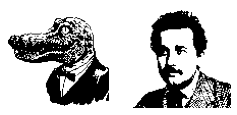

In [4]:
img1 = plt.imread('source/AlbertGator.png')
img2 = plt.imread('source/AlbertEinstein.png')
img_list = [img1, img2]
M = len(img_list)

fig, ax = plt.subplots(1,M, figsize=(2*M,2))
for m in range(M):
    ax[m].imshow(img_list[m], cmap='Greys_r')    # pixel values: 0 = black, 1 = white
    ax[m].axis('off')
plt.show()

We have to convert the 2D images to 1D vectors, which will be the patterns to be stored. This is done simply by flattening the array. We also have to convert the raw values 0 and 1 to the values of the nodes 1 or -1.

In [5]:
def img2vec(img):
    """
    convert a 2D black & white image to a 1D vector of +/-1.
    input:
    img: 2d-array of binary numbers (0 for black and 1 for white);
         some grayscale images have an extra dimension which is redundant and will be removed.
    output:
    vec: 1d-array of +/-1 values.
    """
    if img.ndim > 2:    # grayscale image with redundant dimension
        img = img[:,:,0]    # remove redundant dimension
    vec = np.reshape(img, -1)    # flatten array
    vec = 1-2*vec    # convert from 0/1 to +/-1
    return vec

def vec2img(vec, shape):
    """
    convert a 1D vector of +/-1 to a 2D black & white image.
    input:
    vec: 1d-array of +/-1 values.
    shape: 2-tuple, shape of the 2d-array.
    output:
    img: 2d-array of binary numbers (0 for black and 1 for white).
    """
    vec = (1-vec)/2
    img = np.reshape(vec, shape)
    return img

When we have converted the images to patterns, we will put them in a 2D array, where each row is a pattern. Then we can create the Hopfield network using these patterns.

In [6]:
shape = img1.shape    # shape of image (shape of 2d-array)
N = np.prod(shape)    # size of network (length of 1d-vector)

patterns = []
for img in img_list:
    vec = img2vec(img)    # convert image to vector
    patterns.append(vec)    # add vector as pattern

net = Hopfield(patterns)    # create Hopfield network

To retrieve a pattern, let us provide a seed, which can be a small section of the image we want to retrieve.

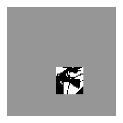

In [7]:
section = np.zeros(shape) + 0.5    # default value 0.5 for gray
section[55:80,45:70] = img1[55:80,45:70]    # choose small section of image
seed = img2vec(section)    # transform section of image to seed pattern
net.set_network(state=seed)    # set network state to the seed pattern

plt.figure(figsize=(2,2))
plt.imshow(section, cmap='Greys_r')
plt.axis('off')
plt.show()

Now we are ready to run the network. To speed things up, we will update 1000 nodes at a time. We might want to record the state of the network after every update. But to see how the network approaches one of the patterns, we only need to record the overlap between the network state and each pattern.

In [8]:
T = 50
overlap_hist = [net.overlap()]
for t in range(T):
    flip = net.updateN(size=1000)
    overlap_hist.append(net.overlap())

Let us visualize the final state of the network.

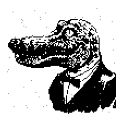

In [9]:
img = vec2img(net.state, shape)    # convert vector to image
plt.figure(figsize=(2,2))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.show()

We have successfully retrieved the full image!

Let us plot how the overlaps have changed over time.

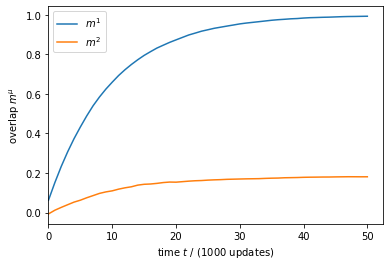

In [10]:
overlap_hist = np.asarray(overlap_hist)
plt.figure()
for mu in range(M):
    plt.plot(overlap_hist[:,mu], label=r'$m^{%d}$' % (mu+1))
plt.xlim(xmin=0)
plt.xlabel(r'time $t$ / (1000 updates)')
plt.ylabel(r'overlap $m^{\mu}$')
plt.legend(loc='upper left')
plt.show()

It can be seen that the network moved quickly towards pattern 1, i.e., retrieving the first image. This is expected because the seed that we provided at the beginning was part of this very image.

Since our patterns are images, it may be fun to watch how the image is changing over time as the network runs. So let us record the retrieval process as a movie, which can be done as follows.

In [11]:
import matplotlib.animation as anim

plt.rcParams["animation.html"] = "jshtml"
fig, ax = plt.subplots(figsize=(2,2))
ax.axis('off')

net.set_network(state=seed)
frame = vec2img(net.state, shape)
img = ax.imshow(frame, cmap='Greys_r', interpolation='none')

def animate(t):
    if t > 0:
        flip = net.updateN(size=1000)
    frame = vec2img(net.state, shape)
    img.set_data(frame)

mov = anim.FuncAnimation(fig, animate, interval=100)
# mov.save('figures/retrieve_img1.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
plt.close()

In [12]:
mov